## 🌐 Connect to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/
%cd [2024-2025] AN2DL Homework 1/

Mounted at /gdrive
/gdrive/My Drive
/gdrive/My Drive/[2024-2025] AN2DL Homework 1


## ⚙️ Import Libraries

In [ ]:
import numpy as np
import logging

import tensorflow as tf
import keras as tfk
from keras import layers as tfkl

# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seeds for NumPy and TensorFlow
seed = 29
np.random.seed(seed)
tf.random.set_seed(seed);

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## ⏳ Load and Clean the Dataset

In [3]:
# Load the dataset
data = np.load('training_set.npz')

# Put images on X and labels on y
X = data['images']
y = data['labels']

print("Initial X shape: ", X.shape)
print("Initial y shape: ", y.shape)

# Delete outliers from the dataset
delete_index = 11958
X = X[:delete_index + 1]
y = y[:delete_index + 1]

print("Final X shape: ", X.shape)
print("Final y shape: ", y.shape)

Initial X shape:  (13759, 96, 96, 3)
Initial y shape:  (13759, 1)
Final X shape:  (11959, 96, 96, 3)
Final y shape:  (11959, 1)


## 🚆 Split into train, validation and train sets

In [25]:
# Split the dataset into a training + validation set, and a separate test set
# The test set is the 10% of the whole dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=seed)

# Further split the training + validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
   test_size=len(X_test),
    stratify=y_train_val,
    random_state=seed)

# Convert labels to one-hot encoding
y_train = tfk.utils.to_categorical(y_train, 8)
y_val = tfk.utils.to_categorical(y_val, 8)
y_test = tfk.utils.to_categorical(y_test, 8)

# Define a simple augmentation sequence
augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='Augmentation')

# Print the shapes of the resulting sets
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)

Training set shape:	 (9567, 96, 96, 3) (9567, 8)
Validation set shape:	 (1196, 96, 96, 3) (1196, 8)
Test set shape:		 (1196, 96, 96, 3) (1196, 8)


## 🧮 Define Network Parameters

In [26]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

# Number of training epochs
epochs = 100

# Number of samples passed to the network at each training step
batch_size = 128

learning_rate = 1e-4

# L2 Lambda for regularization
l2_lambda = 1e-5

# Print the shapes of the model
print('Input shape:\t', input_shape)
print('Output shape:\t', output_shape)

Input shape:	 (96, 96, 3)
Output shape:	 8


## 🔨 Build the model

In [27]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=augmentation,
    l2_lambda=l2_lambda
):

    # Initialize inputs
    inputs = tfkl.Input(shape=input_shape)

    # Initialise regularizer
    regularizer = tfk.regularizers.l2(l2_lambda)

    # Perform image augmentation
    x = augmentation(inputs)

    # First Convolutional Layer Group
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Second Convolutional Layer Group
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Third Convolutional Layer Group
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Fourth Convolutional Layer Group
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Fifth Convolutional Layer Group
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', kernel_regularizer=regularizer)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling2D(pool_size=2)(x)

    # Fully Connected Blocks
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(units=1024, activation='relu')(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.Dense(units=1024, activation='relu')(x)
    x = tfkl.Dropout(0.5)(x)
    outputs = tfkl.Dense(units=output_shape, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Augmentation (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,1

 Total params: 20,645,576 (78.76 MB)

 Trainable params: 20,642,632 (78.75 MB)

 Non-trainable params: 2,944 (11.50 KB)

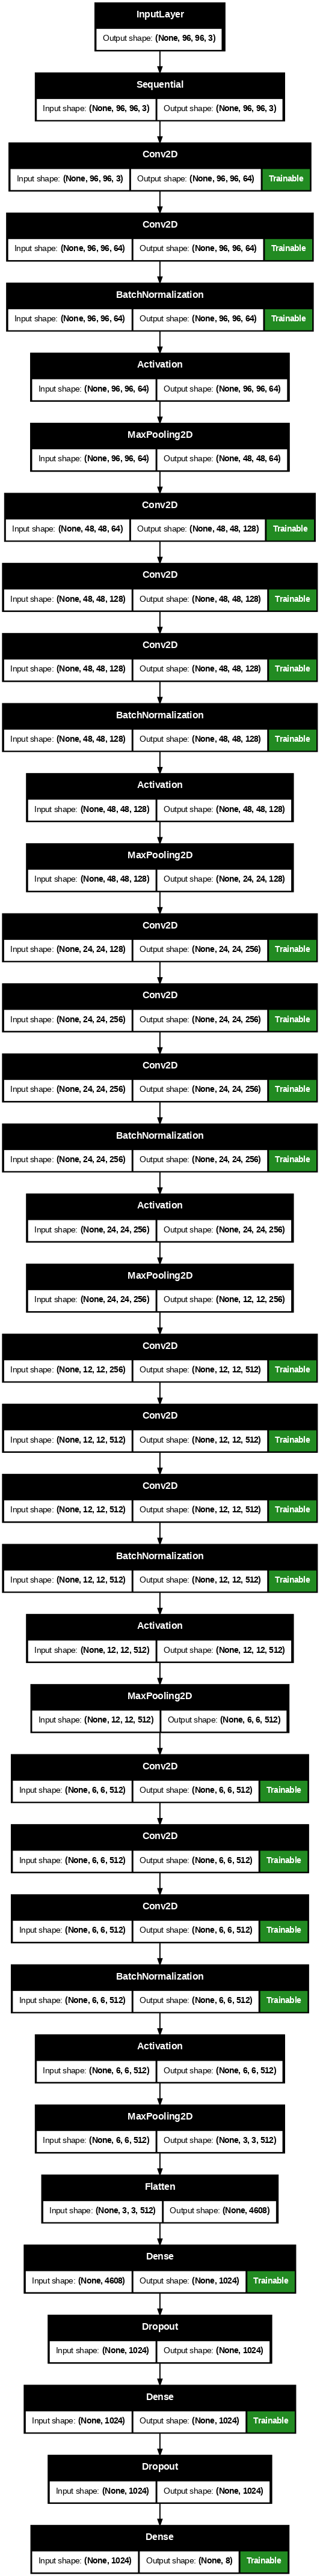

In [28]:
# Build the model
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=False, show_trainable=False)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🧠 Train the Model

In [ ]:
# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# Create a LearningRate Scheduler, which reduces learning rate if val loss doesn't improve
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# Store the callback in a list
callbacks = [early_stopping, lr_scheduler]

In [30]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

print('Training finished.')

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 625ms/step - accuracy: 0.1522 - loss: 2.6438 - val_accuracy: 0.2241 - val_loss: 13.7834 - learning_rate: 1.0000e-04
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 500ms/step - accuracy: 0.1743 - loss: 2.0804 - val_accuracy: 0.2074 - val_loss: 15.9955 - learning_rate: 1.0000e-04
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - accuracy: 0.1894 - loss: 2.0770 - val_accuracy: 0.2166 - val_loss: 23.8876 - learning_rate: 1.0000e-04
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 509ms/step - accuracy: 0.1899 - loss: 2.0762 - val_accuracy: 0.1823 - val_loss: 29.2619 - learning_rate: 1.0000e-04
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 491ms/step - accuracy: 0.1887 - loss: 2.0685 - val_accuracy: 0.1371 - val_loss: 47.1774 - learning_rate: 1.0000e-04
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 492ms/step - accuracy: 0.1886 - loss: 2.0650 - val_accuracy: 0.1371 - val_loss: 62.4510 - learning_rate: 1.0000e-04
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 491

## ✌ Verify with Validation and Test sets

In [31]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Calculate final test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Final validation accuracy: 22.41%
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.2189 - loss: 13.9249
Test Accuracy: 22.83%
Test Loss: 13.7657


In [32]:
# Save the model to export it and delete it to save space
model.save('weights.keras')
del model

## ✅ Verify that the weights work as intended

In [33]:
# Load the model
model = tfk.models.load_model('weights.keras')

# Predict on test set and validation set
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Convert to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Compute accuracy
test_accuracy = np.sum(y_test_classes == y_pred_test_classes) / len(y_test_classes)
val_accuracy = np.sum(y_val_classes == y_pred_val_classes) / len(y_val_classes)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Validation Accuracy: 0.2241
Test Accuracy: 0.2283


## 📊 Create the model.py

In [19]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


## 📁 Export the ZIP file

In [20]:
# Set filename for the zip file
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Create a zip file with the provided filename, containing model and weights
!zip {filename} model.py weights.keras

  adding: model.py (deflated 48%)
  adding: weights.keras (deflated 10%)
